In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from utils.analisis import describe_categoricas
from utils.analisis import graficar_EDA_target
from utils.almacenamiento import leer_csv_desde_gcs

from google.cloud import bigquery

import warnings

warnings.filterwarnings('ignore')

# Analisis Exploratorio

## Application_train

### Lectura de datos
Leemos los datos de los csv para y creamos el dataframe y el diccionario de datos

In [2]:
data = leer_csv_desde_gcs(archivo = "application_train.csv")
data.head()

Leyendo archivo desde: gs://home-credit-risk-data-bucket/data/application_train.csv


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
data.shape

(307511, 122)

In [4]:
dict_descriptions = {}
df_descriptions = leer_csv_desde_gcs(archivo='HomeCredit_columns_description.csv')
np_descriptions = df_descriptions[df_descriptions['Table']=='application_{train|test}.csv'][['Row','Description']].values
for key,value in np_descriptions:
    dict_descriptions[key] = value

Leyendo archivo desde: gs://home-credit-risk-data-bucket/data/HomeCredit_columns_description.csv


### Informacion de las variables

Las variables se pueden dividir segun el tipo de informacion que proporcionan del cliente

In [5]:
inf_personal = ['CODE_GENDER','CNT_CHILDREN','NAME_FAMILY_STATUS','CNT_FAM_MEMBERS','DAYS_BIRTH']
inf_laboral = ['AMT_INCOME_TOTAL','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','OCCUPATION_TYPE','DAYS_EMPLOYED','ORGANIZATION_TYPE']
inf_posesiones = ['FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_HOUSING_TYPE','OWN_CAR_AGE']
inf_prestamo = ['NAME_CONTRACT_TYPE','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','NAME_TYPE_SUITE','DAYS_REGISTRATION','DAYS_ID_PUBLISH']
inf_comunicacion = ['FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL']
inf_direccion = ['REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY','REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION',
                'LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY']
inf_scores = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']
inf_documents = [var for var in data if 'FLAG_DOCUMENT' in var]
inf_bureauCalls = [var for var in data if 'AMT_REQ_CREDIT_BUREAU' in var]
inf_agregation = [var for var in data if '_AVG' in var or '_MEDI' in var or '_MODE' in var]

Tambien segun el tipo de variable que sean numericas o categoricas(cat. ordinales o cat. nominales)

In [6]:
variables_obj = [var for var in data if data[var].nunique()<60 or data[var].dtype=='O']
variables_num = list ( set(data.columns) - set(variables_obj) )
print(f"Numero de variables categoricas: {len(variables_obj)}")
print(f"Numero de variables numericas: {len(variables_num)}")

Numero de variables categoricas: 72
Numero de variables numericas: 50


Podemos notar que tenemos un desbalanceo entre las clases de la variable target.

In [7]:
val_target = data['TARGET'].value_counts()
val_target = val_target/sum(val_target)
np.round(val_target*100,2)

TARGET
0    91.93
1     8.07
Name: count, dtype: float64

### Graficas univariadas y bivariadas (variable vs target)

#### Informacion personal

- CODE_GENDER : Genero de la persona (M,F).
- CNT_CHILDREN : Numero de hijos.
- NAME_FAMILY_STATUS : Estado civil de la persona.
- CNT_FAM_MEMBERS : Numero de miembros de la familia.
- DAYS_BIRTH : Fecha de nacimiento (dias atras).

In [8]:
df_inf_personal = data[inf_personal+['TARGET']]

df_inf_personal['CNT_CHILDREN'] = df_inf_personal['CNT_CHILDREN'].apply(
    lambda x: f"{x} hijos" if pd.notna(x) else "No info"
)
df_inf_personal['CNT_FAM_MEMBERS'] = df_inf_personal['CNT_FAM_MEMBERS'].apply(
    lambda x: f"{int(x)} mbrs" if pd.notna(x) else "No info"
)

In [9]:
var_cat = ['CODE_GENDER','NAME_FAMILY_STATUS','CNT_CHILDREN','CNT_FAM_MEMBERS']
var_num = ['DAYS_BIRTH']

In [10]:
df_inf_personal[var_num].describe()

,DAYS_BIRTH
count,307511.000000
mean,-16036.995067
std,4363.988632
min,-25229.000000
25%,-19682.000000
50%,-15750.000000
75%,-12413.000000
max,-7489.000000


In [11]:
describe_categoricas(df_inf_personal,var_cat,6)

porcentaje  cantidad
                   clases                                   
CODE_GENDER        F                       65.834%    202448
                   M                       34.164%    105059
                   XNA                      0.001%         4
NAME_FAMILY_STATUS Married                 63.878%    196432
                   Single / not married    14.778%     45444
                   Civil marriage           9.683%     29775
                   Separated                6.429%     19770
                   Widow                    5.232%     16088
                   Unknown                  0.001%         2
CNT_CHILDREN       0 hijos                 70.037%    215371
                   1 hijos                 19.875%     61119
                   2 hijos                  8.699%     26749
                   3 hijos                  1.209%      3717
                   4 hijos                   0.14%       429
                   5 hijos                  0.027%        84
                   otros                    0.007%        21
CNT_FAM_MEMBERS    2 mbrs                  51.496%    158357
                   1 mbrs                  22.063%     67847
                   3 mbrs                  17.105%     52601
                   4 mbrs                   8.031%     24697
                   5 mbrs                   1.131%      3478
                   6 mbrs                   0.133%       408
                   otros                    0.014%        42

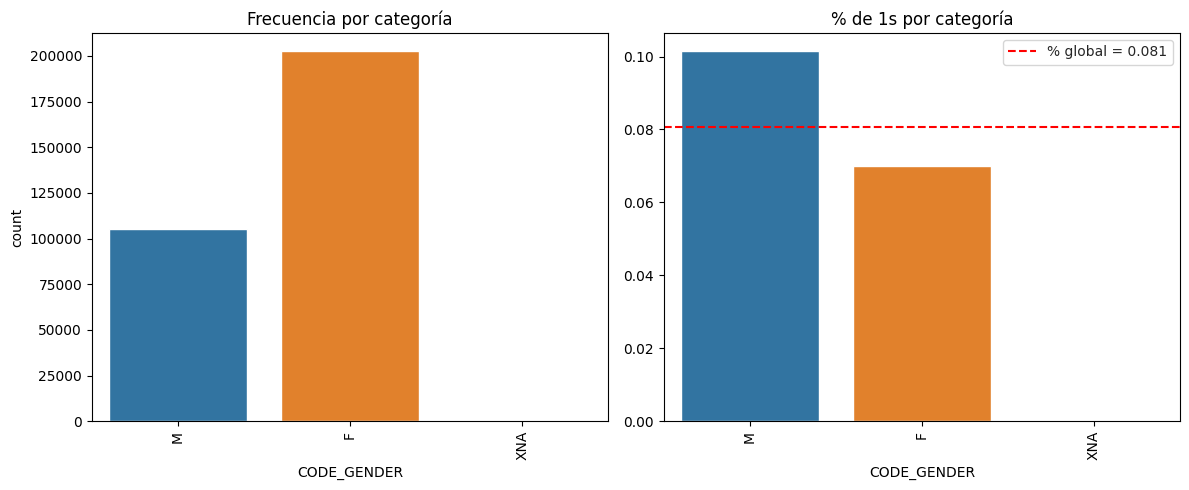

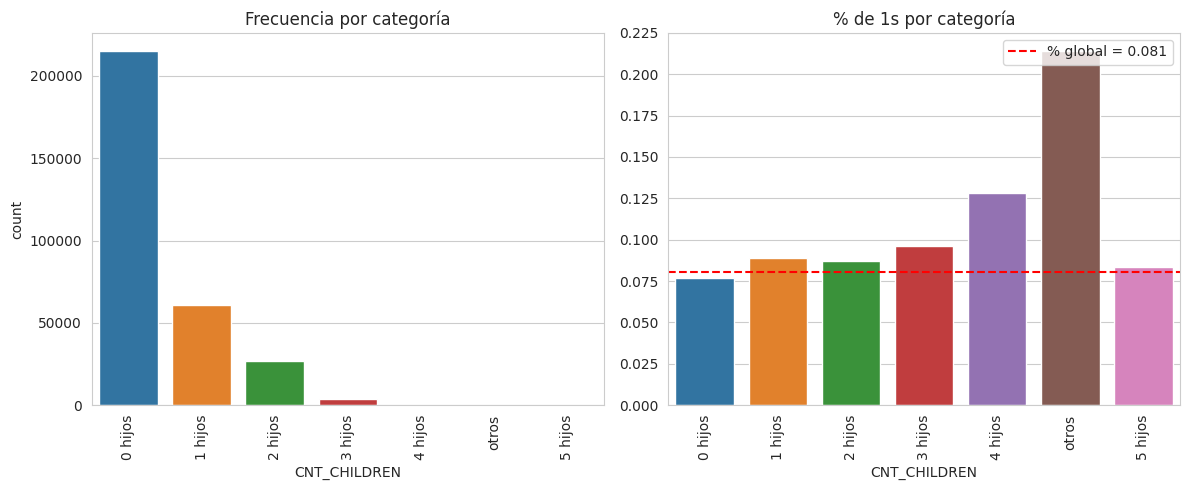

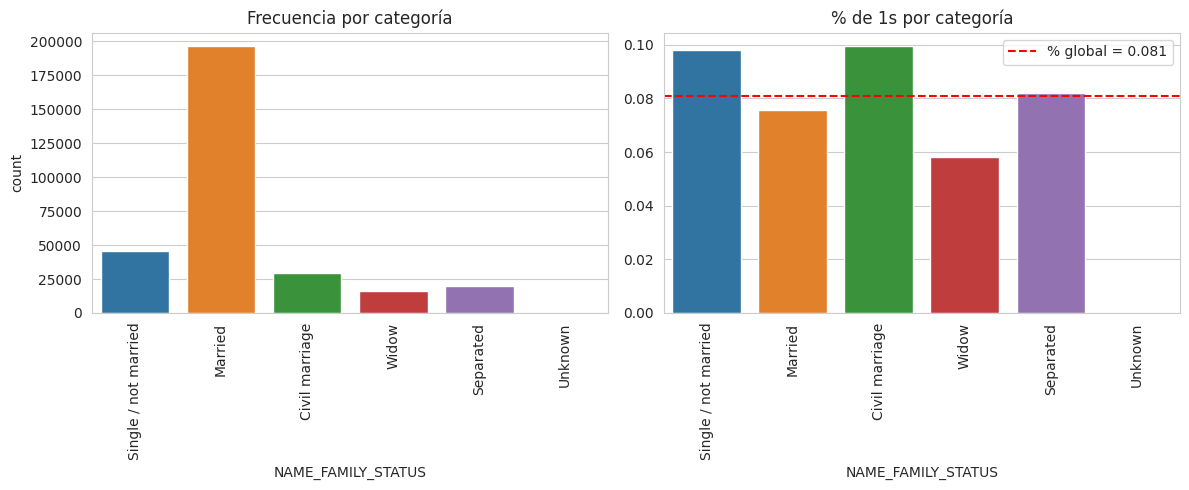

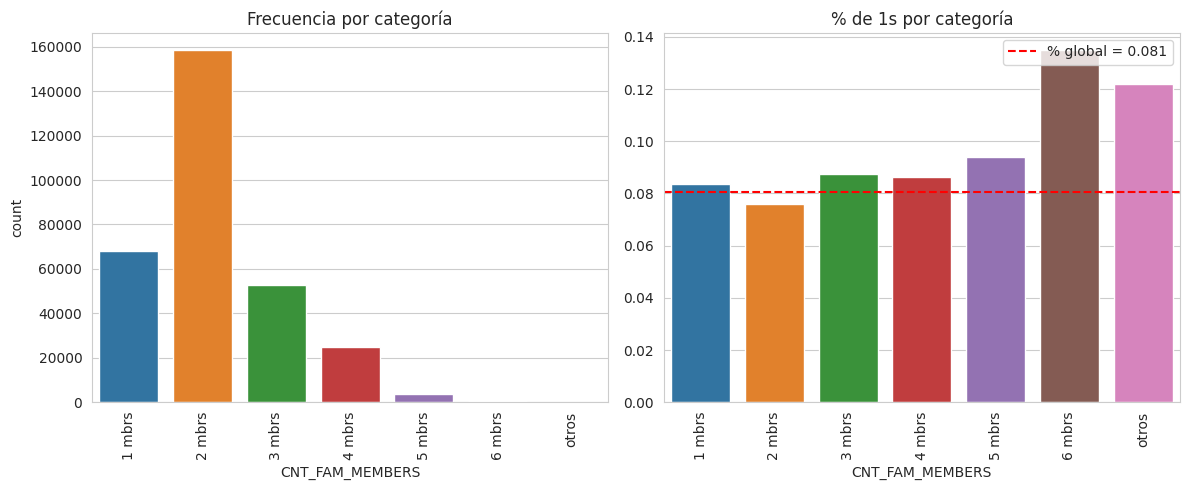

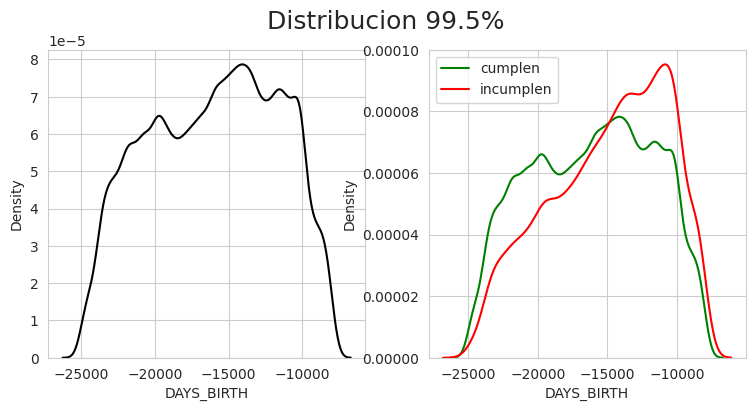

In [12]:
graficar_EDA_target(df_inf_personal,'TARGET',inf_personal,6)

#### Informacion Laboral
- AMT_INCOME_TOTAL : Ingreso total de la persona.
- NAME_INCOME_TYPE : Tipo del ingreso de la persona.
- NAME_EDUCATION_TYPE : Tipo de educacion de la persona.
- OCCUPATION_TYPE : Tipo de ocupacion
- DAYS_EMPLOYED : Dias de desempleado que tiene la persona
- ORGANIZATION_TYPE : El tipo de la organizacion para la cual trabaja.

In [13]:
var_cat = ['NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','OCCUPATION_TYPE','ORGANIZATION_TYPE']
var_num = ['AMT_INCOME_TOTAL','DAYS_EMPLOYED']

In [14]:
data[var_num].describe()

,AMT_INCOME_TOTAL,DAYS_EMPLOYED
count,3.075110e+05,307511.000000
mean,1.687979e+05,63815.045904
std,2.371231e+05,141275.766519
min,2.565000e+04,-17912.000000
25%,1.125000e+05,-2760.000000
50%,1.471500e+05,-1213.000000
75%,2.025000e+05,-289.000000
max,1.170000e+08,365243.000000


In [15]:
describe_categoricas(data,var_cat,8)

porcentaje  cantidad
                    clases                                            
NAME_INCOME_TYPE    Working                          51.632%    158774
                    Commercial associate             23.289%     71617
                    Pensioner                        18.003%     55362
                    State servant                     7.058%     21703
                    Unemployed                        0.007%        22
                    Student                           0.006%        18
                    Businessman                       0.003%        10
                    Maternity leave                   0.002%         5
NAME_EDUCATION_TYPE Secondary / secondary special    71.019%    218391
                    Higher education                 24.345%     74863
                    Incomplete higher                 3.342%     10277
                    Lower secondary                   1.241%      3816
                    Academic degree                   0.053%       164
OCCUPATION_TYPE     nulo                             31.346%     96391
                    Laborers                         17.946%     55186
                    Sales staff                      10.439%     32102
                    Core staff                        8.966%     27570
                    Managers                           6.95%     21371
                    Drivers                            6.05%     18603
                    High skill tech staff             3.701%     11380
                    Accountants                       3.191%      9813
                    otros                             8.636%     26558
ORGANIZATION_TYPE   Business Entity Type 3            22.11%     67992
                    XNA                              18.007%     55374
                    Self-employed                    12.491%     38412
                    Other                             5.425%     16683
                    Medicine                           3.64%     11193
                    Business Entity Type 2            3.432%     10553
                    Government                        3.383%     10404
                    School                            2.892%      8893
                    otros                            26.073%     80176

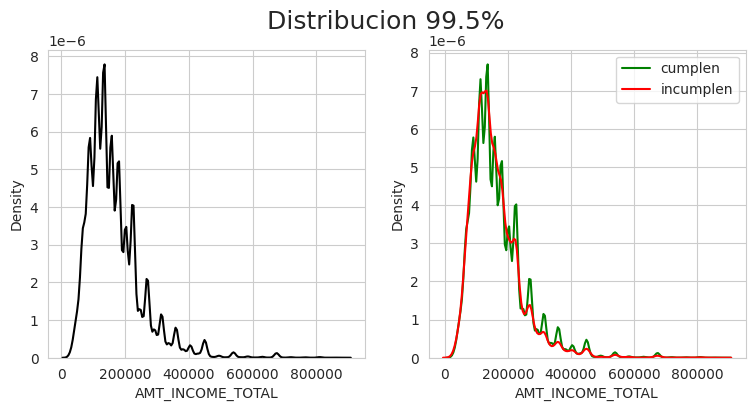

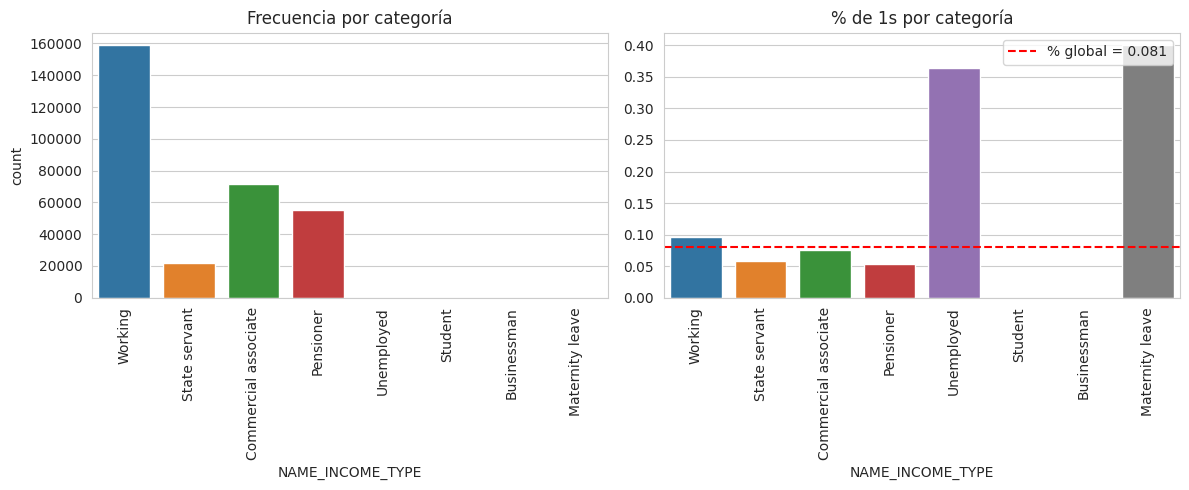

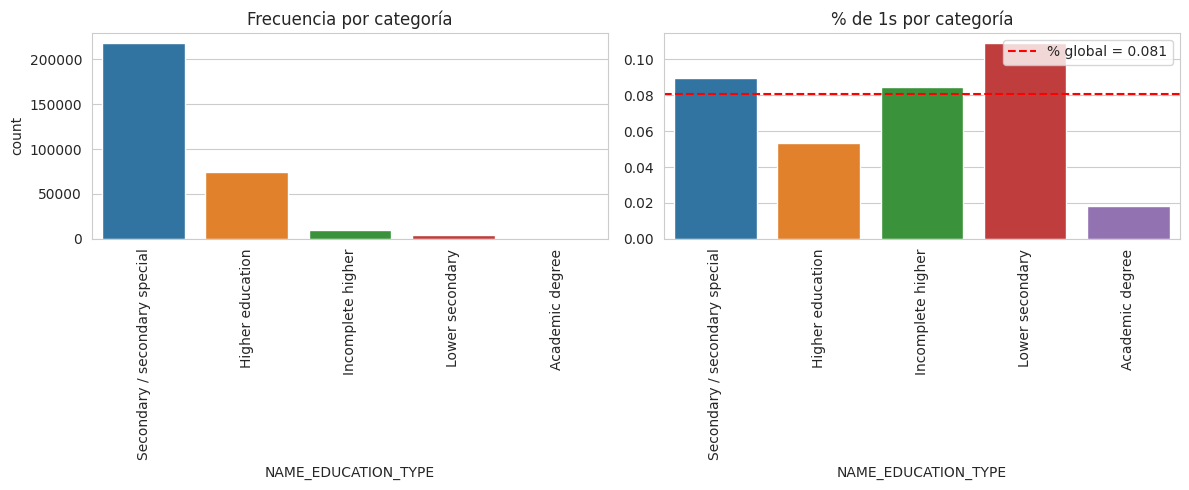

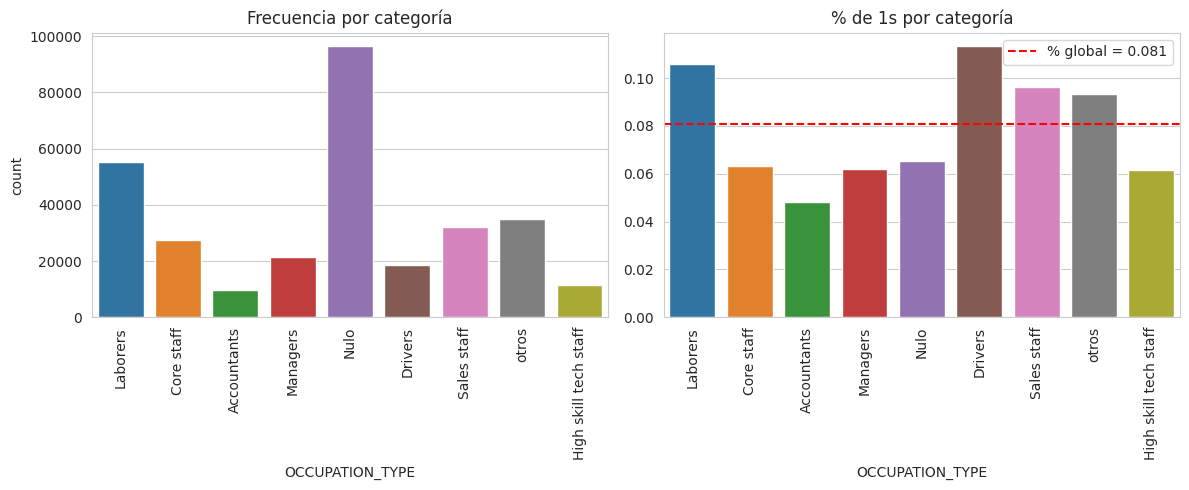

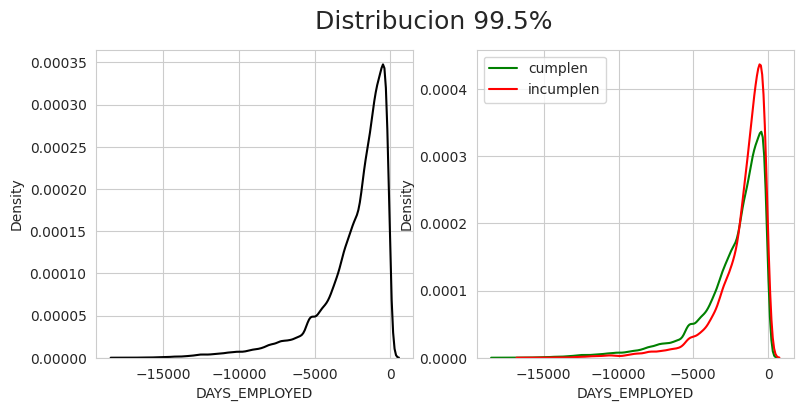

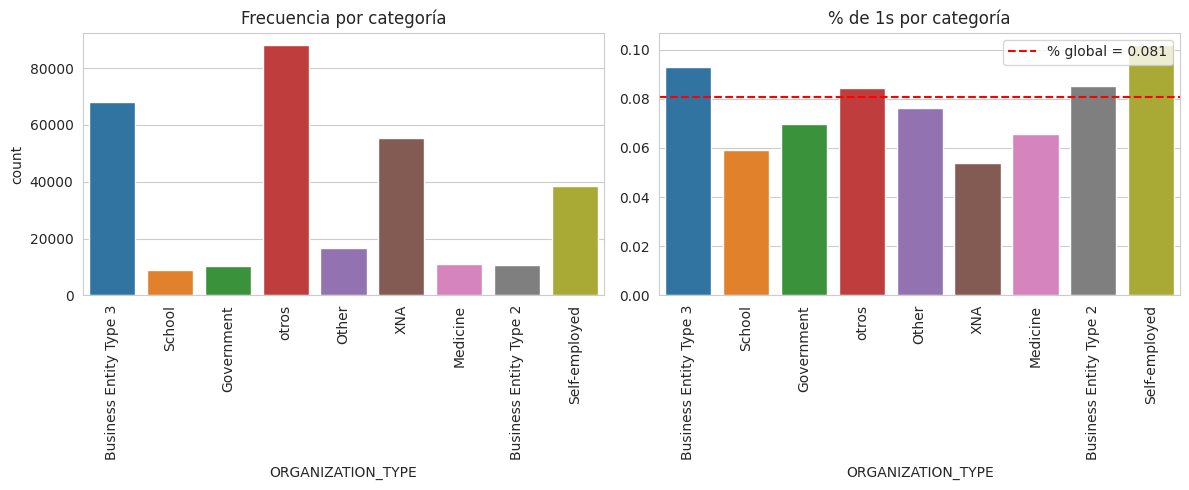

In [16]:
graficar_EDA_target(data,'TARGET',inf_laboral)

#### Informacion Posesion
- FLAG_OWN_CAR : Si la persona tiene o no carro propio
- FLAG_OWN_REALTY : Si la persona tiene una casa o piso propio
- NAME_HOUSING_TYPE : Situacion de vivienda del cliente
- OWN_CAR_AGE : Anios que tiene el carro propio

In [17]:
var_cat = ['FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_HOUSING_TYPE']
var_num = ['OWN_CAR_AGE']

In [18]:
data[var_num].describe()

,OWN_CAR_AGE
count,104582.000000
mean,12.061091
std,11.944812
min,0.000000
25%,5.000000
50%,9.000000
75%,15.000000
max,91.000000


In [19]:
describe_categoricas(data,var_cat,12)

porcentaje  cantidad
                  clases                                  
FLAG_OWN_CAR      N                      65.989%    202924
                  Y                      34.011%    104587
FLAG_OWN_REALTY   Y                      69.367%    213312
                  N                      30.633%     94199
NAME_HOUSING_TYPE House / apartment      88.734%    272868
                  With parents            4.826%     14840
                  Municipal apartment     3.637%     11183
                  Rented apartment        1.587%      4881
                  Office apartment        0.851%      2617
                  Co-op apartment         0.365%      1122

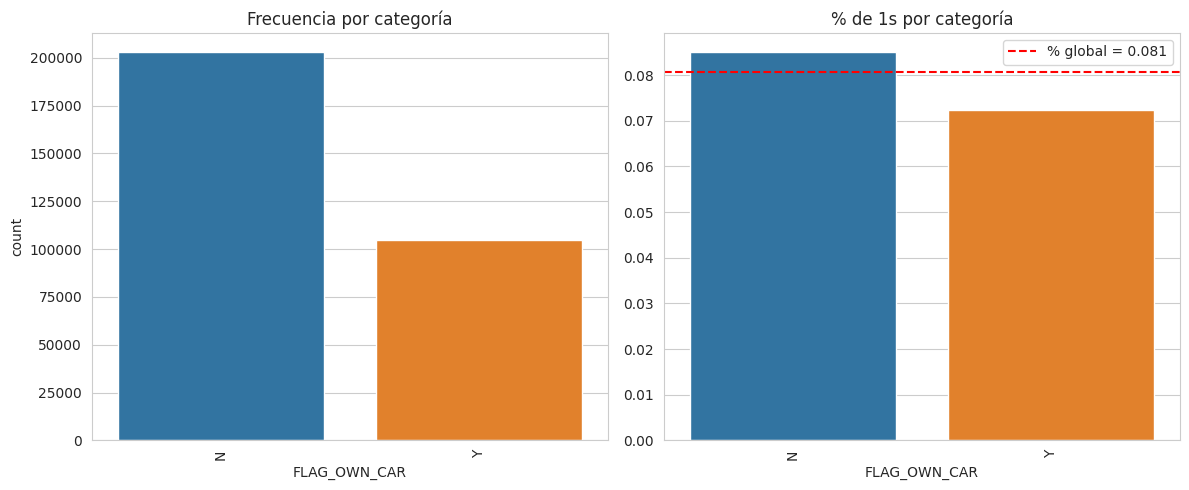

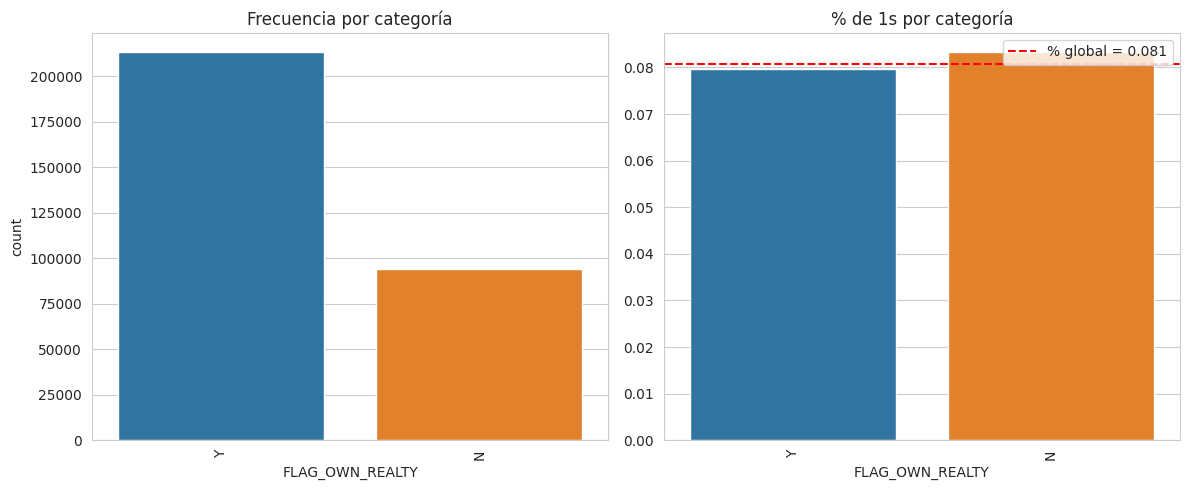

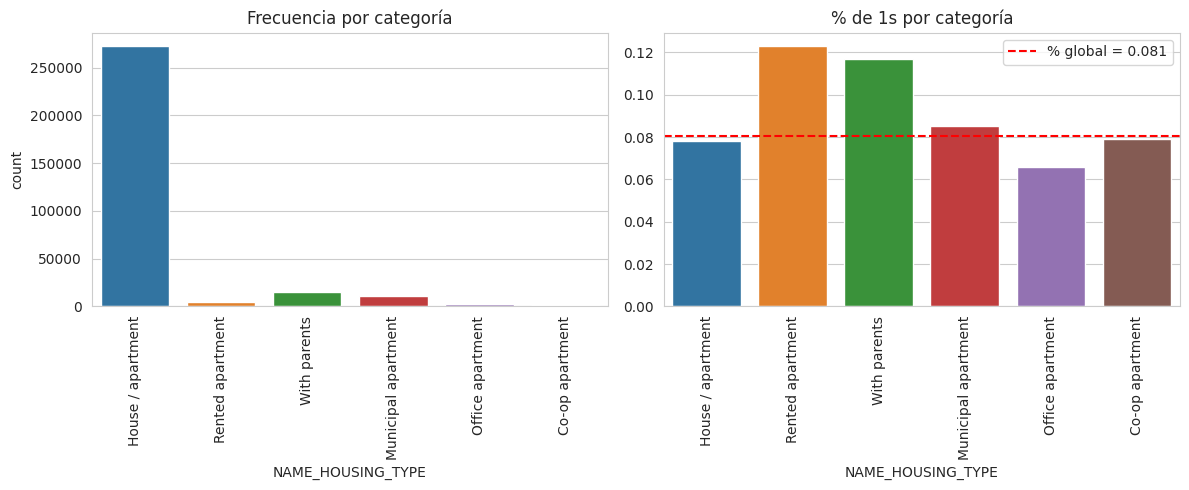

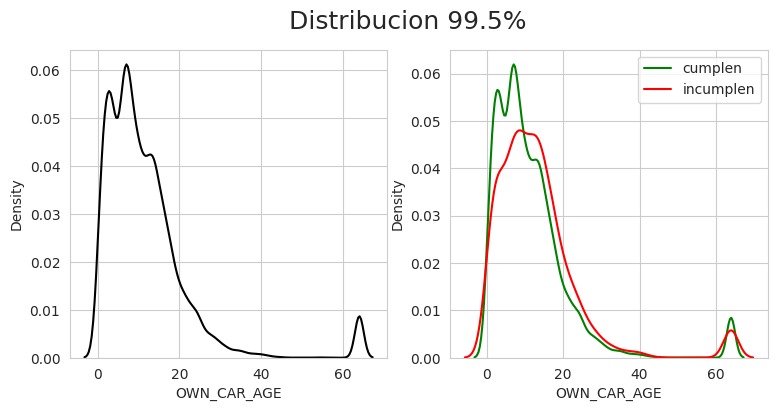

In [20]:
graficar_EDA_target(data,'TARGET',inf_posesiones)

#### Informacion del prestamo
- NAME_CONTRACT_TYPE : Tipo de prestamo.
- AMT_CREDIT : Monto que se le prestara a la persona.
- AMT_ANNUITY : Monto anual a pagar por anio
- AMT_GOODS_PRICE : Monto de los bienes por cual fue otorgado el prestamo.
- NAME_TYPE_SUITE : Con quien fue la persona a pedir el prestamo
- DAYS_REGISTRATION : Cuantos dias antes de la aplicacion al prestamo el cliente cambio su registro.
- DAYS_ID_PUBLISH : Cuantos dias antes de la aplicacion al prestamo el cliente cambio su documento de identidad.

In [21]:
var_cat = ['NAME_CONTRACT_TYPE','NAME_TYPE_SUITE']
var_num = ['AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_REGISTRATION','DAYS_ID_PUBLISH']

In [22]:
data[var_num].describe().round(2)

,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_REGISTRATION,DAYS_ID_PUBLISH
count,307511.00,307499.00,307233.00,307511.00,307511.00
mean,599026.00,27108.57,538396.21,-4986.12,-2994.20
std,402490.78,14493.74,369446.46,3522.89,1509.45
min,45000.00,1615.50,40500.00,-24672.00,-7197.00
25%,270000.00,16524.00,238500.00,-7479.50,-4299.00
50%,513531.00,24903.00,450000.00,-4504.00,-3254.00
75%,808650.00,34596.00,679500.00,-2010.00,-1720.00
max,4050000.00,258025.50,4050000.00,0.00,0.00


In [23]:
describe_categoricas(data,var_cat,8)

porcentaje  cantidad
                   clases                              
NAME_CONTRACT_TYPE Cash loans         90.479%    278232
                   Revolving loans     9.521%     29279
NAME_TYPE_SUITE    Unaccompanied      80.819%    248526
                   Family             13.056%     40149
                   Spouse, partner     3.697%     11370
                   Children            1.062%      3267
                   Other_B             0.576%      1770
                   nulo                 0.42%      1292
                   Other_A             0.282%       866
                   Group of people     0.088%       271

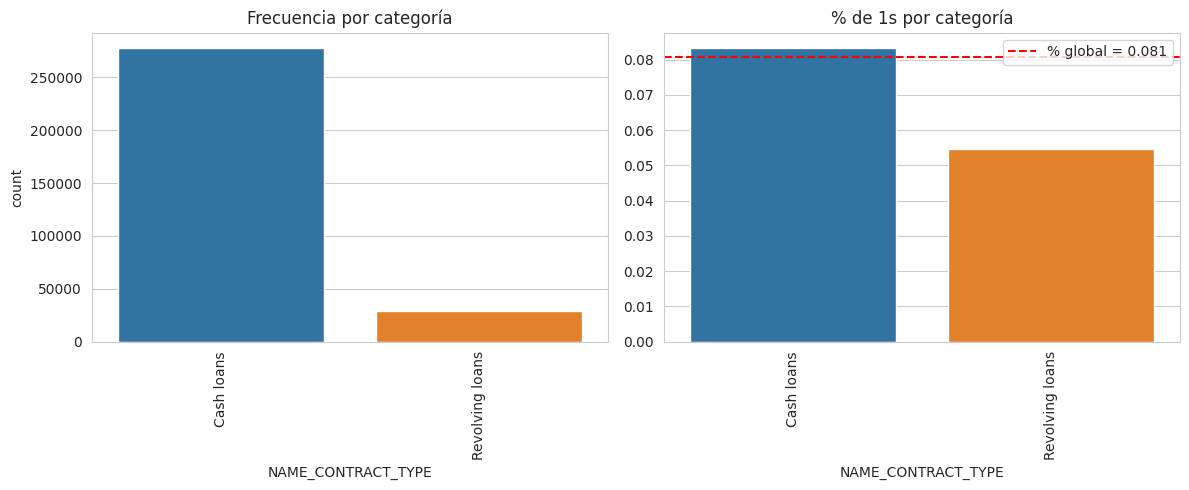

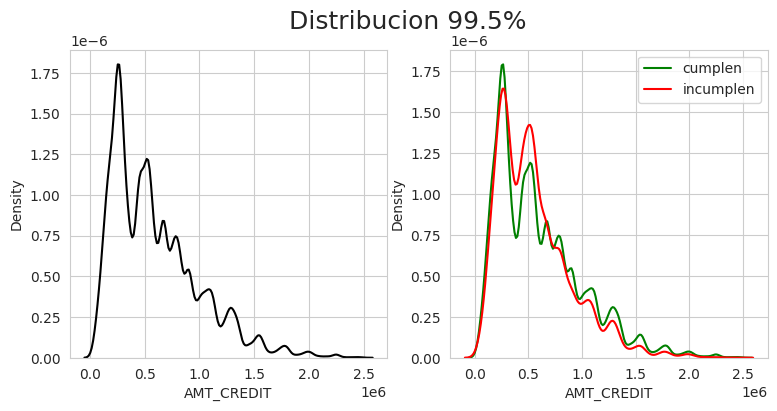

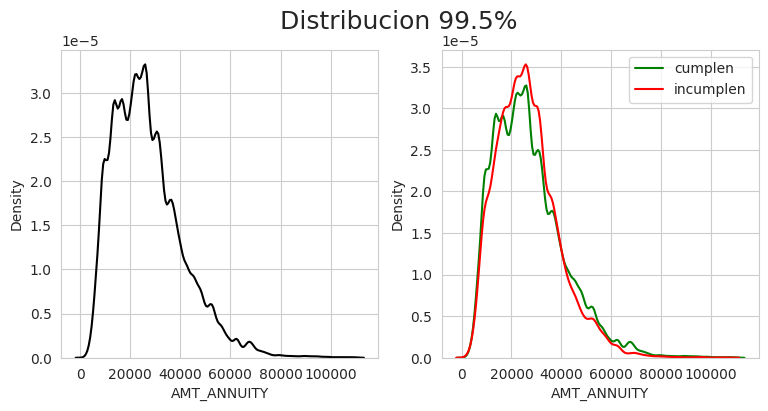

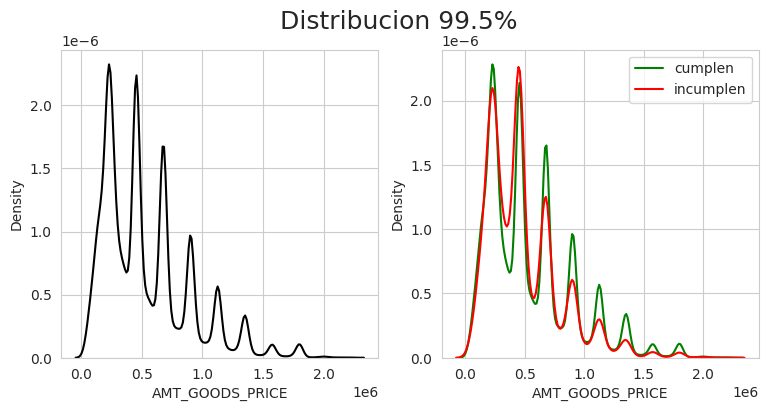

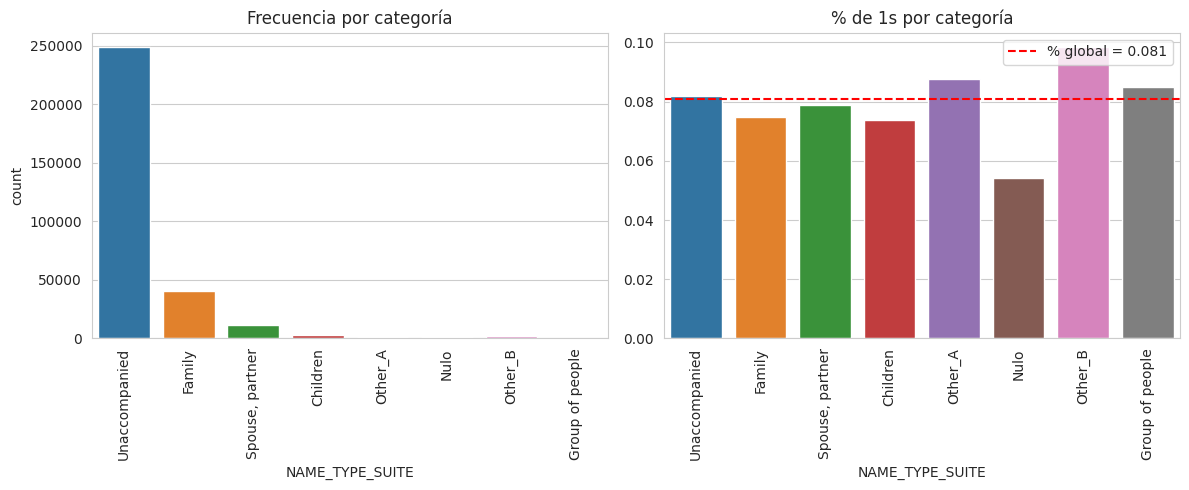

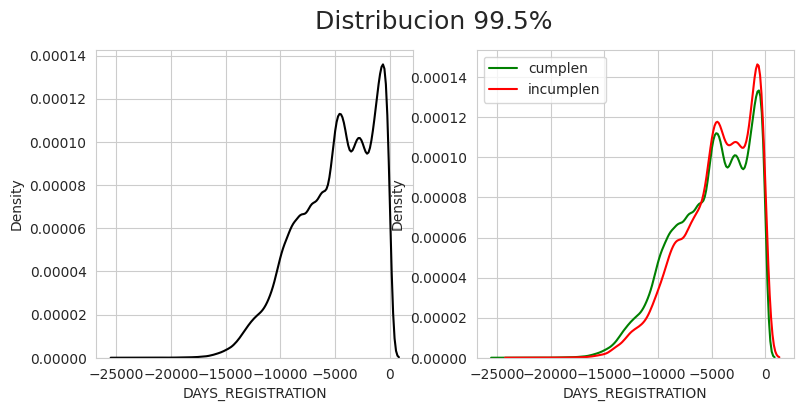

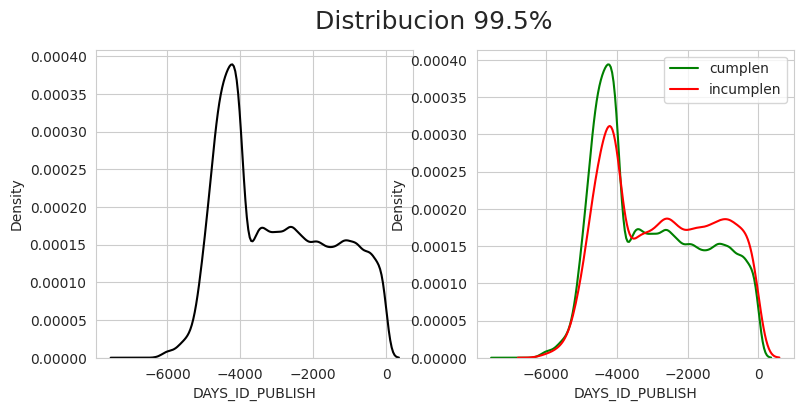

In [24]:
graficar_EDA_target(data,'TARGET',inf_prestamo)

#### Informacion comunicacion
- FLAG_MOBIL : El cliente proporciono su numero de telofono?
- FLAG_CONT_MOBILE : Se contacto al cliente con el numero de telefono?
- FLAG_EMP_PHONE : El cliente proporciono su numero de trabajo?
- FLAG_PHONE : El cliente proporciono su numero de casa?
- FLAG_EMAIL : El cliente proporciono su email?

In [25]:
df_inf_comunicacion = data[inf_comunicacion].copy()
df_inf_comunicacion.replace({1:'si',0:'no'},inplace=True)
df_inf_comunicacion['TARGET'] = data['TARGET'].copy()

In [26]:
describe_categoricas(df_inf_comunicacion,inf_comunicacion)

porcentaje  cantidad
                 clases                     
FLAG_MOBIL       si         100.0%    307510
                 no           0.0%         1
FLAG_EMP_PHONE   si        81.989%    252125
                 no        18.011%     55386
FLAG_CONT_MOBILE si        99.813%    306937
                 no         0.187%       574
FLAG_PHONE       no        71.893%    221080
                 si        28.107%     86431
FLAG_EMAIL       no        94.328%    290069
                 si         5.672%     17442

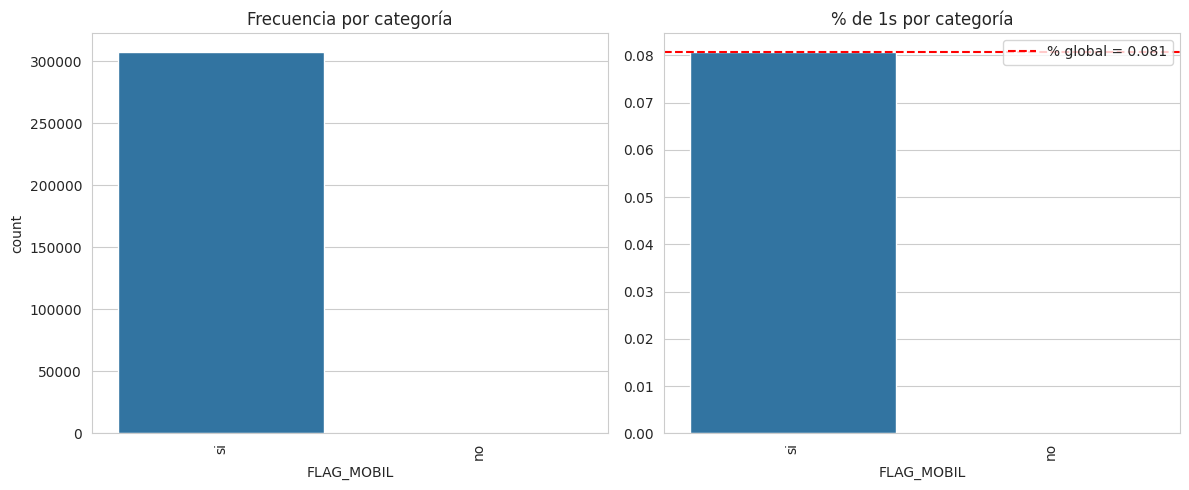

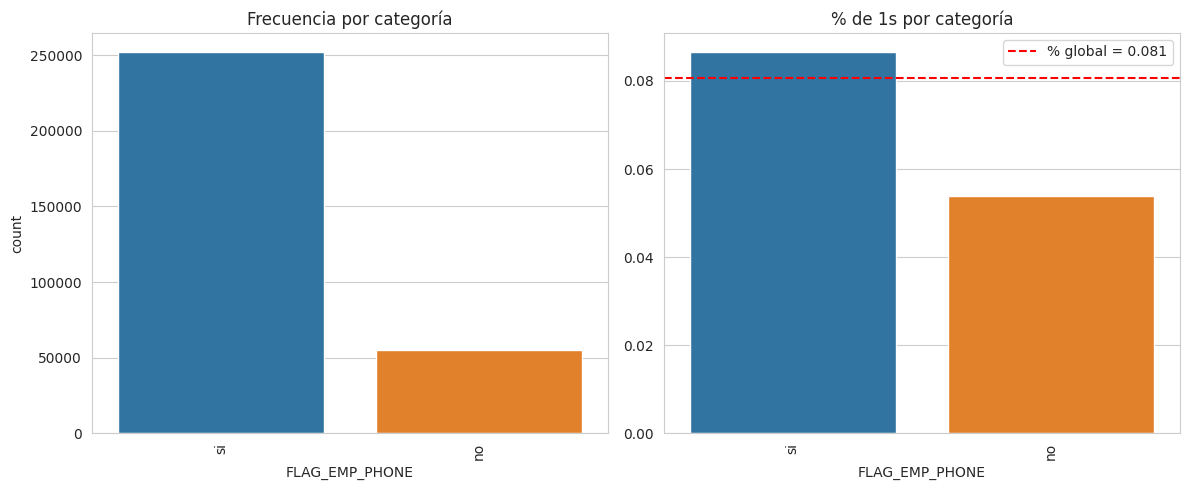

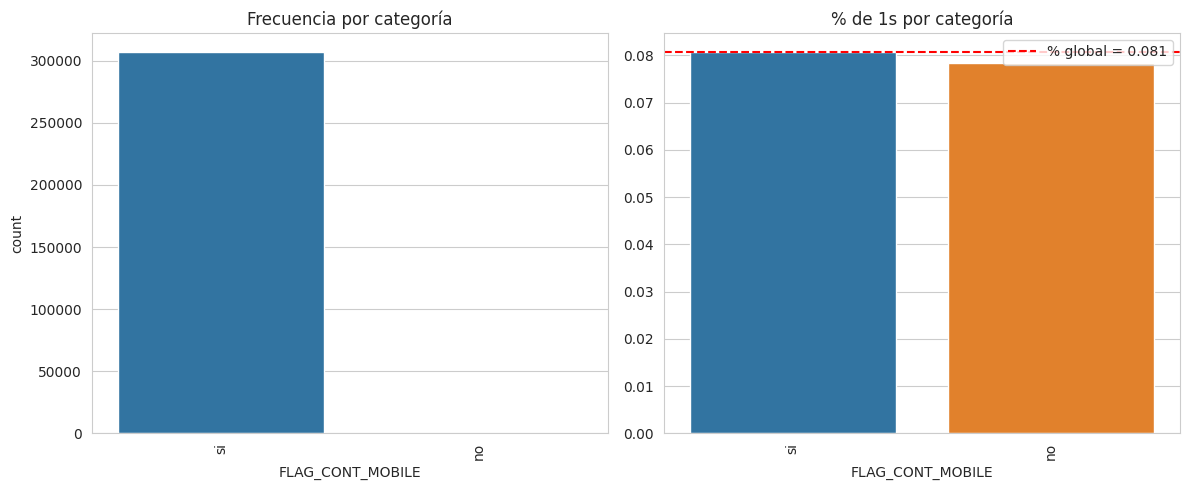

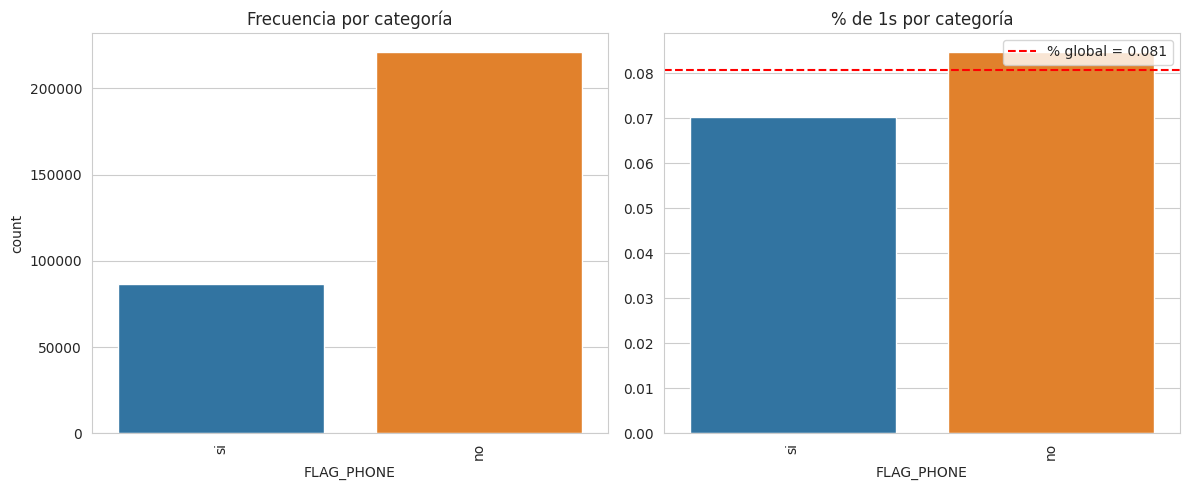

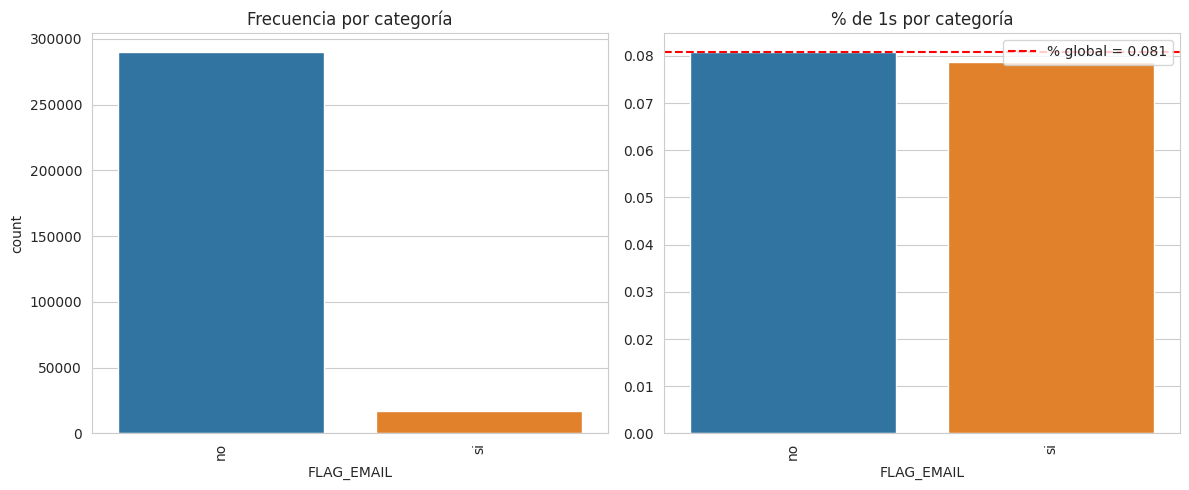

In [27]:
graficar_EDA_target(df_inf_comunicacion,'TARGET',inf_comunicacion)

#### Informacion direccion
- REGION_RATING_CLIENT : Calificacion de la region en la que vive el cliente
- REGION_RATING_CLIENT_W_CITY : Calificacion de la region en la que vive el cliente teniendo en cuenta la ciudad
- REG_REGION_NOT_LIVE_REGION : La dirección permanente del cliente coincide con la dirección de contacto a nivel de región?
- REG_REGION_NOT_WORK_REGION : Similar a la anterior pero indica la region de trabajo
- LIVE_REGION_NOT_WORK_REGION :  Evalúa la coincidencia entre la dirección permanente y la dirección del trabajo a nivel de región.

In [28]:
describe_categoricas(data,inf_direccion)

porcentaje  cantidad
                            clases                     
REGION_RATING_CLIENT        2         73.813%    226984
                            3         15.717%     48330
                            1          10.47%     32197
REGION_RATING_CLIENT_W_CITY 2         74.626%    229484
                            3         14.263%     43860
                            1         11.111%     34167
REG_REGION_NOT_LIVE_REGION  0         98.486%    302854
                            1          1.514%      4657
REG_REGION_NOT_WORK_REGION  0         94.923%    291899
                            1          5.077%     15612
LIVE_REGION_NOT_WORK_REGION 0         95.934%    295008
                            1          4.066%     12503
REG_CITY_NOT_LIVE_CITY      0         92.183%    283472
                            1          7.817%     24039
REG_CITY_NOT_WORK_CITY      0         76.955%    236644
                            1         23.045%     70867
LIVE_CITY_NOT_WORK_CITY     0         82.045%    252296
                            1         17.955%     55215

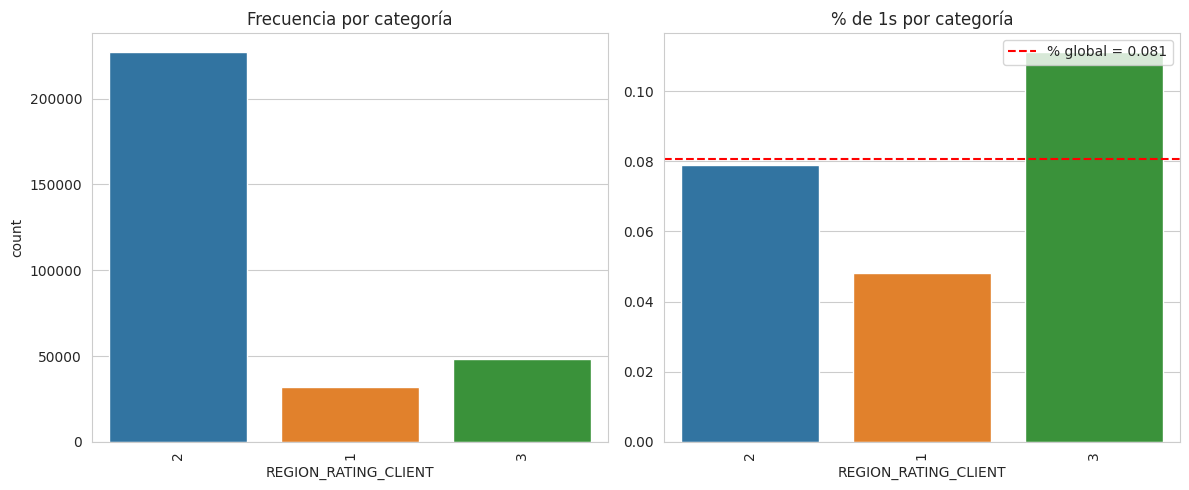

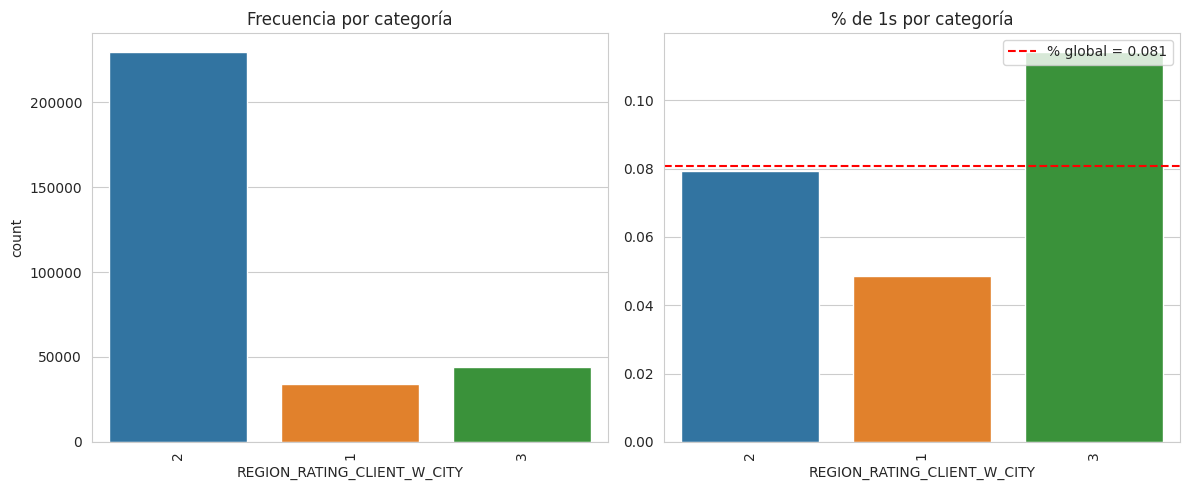

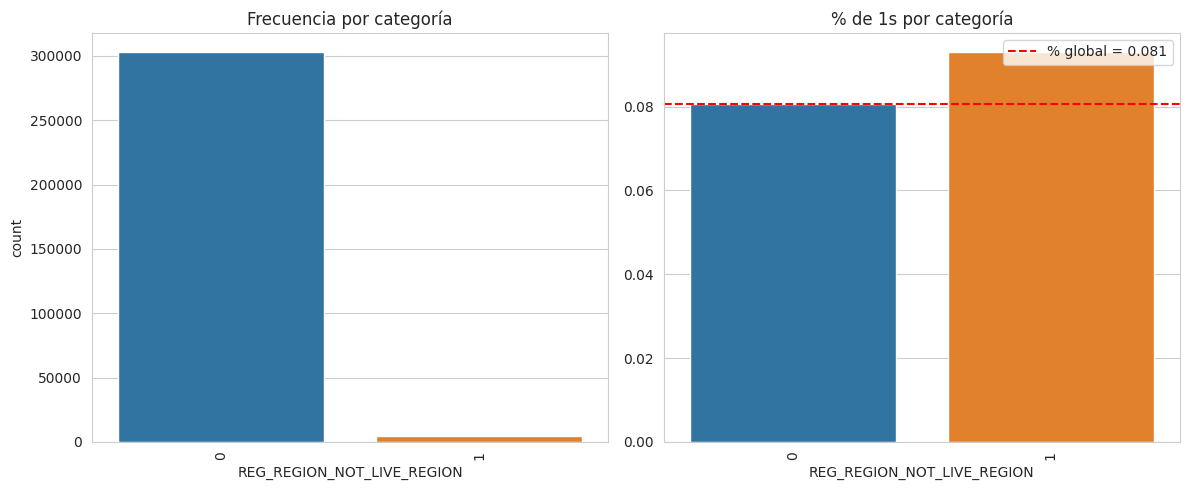

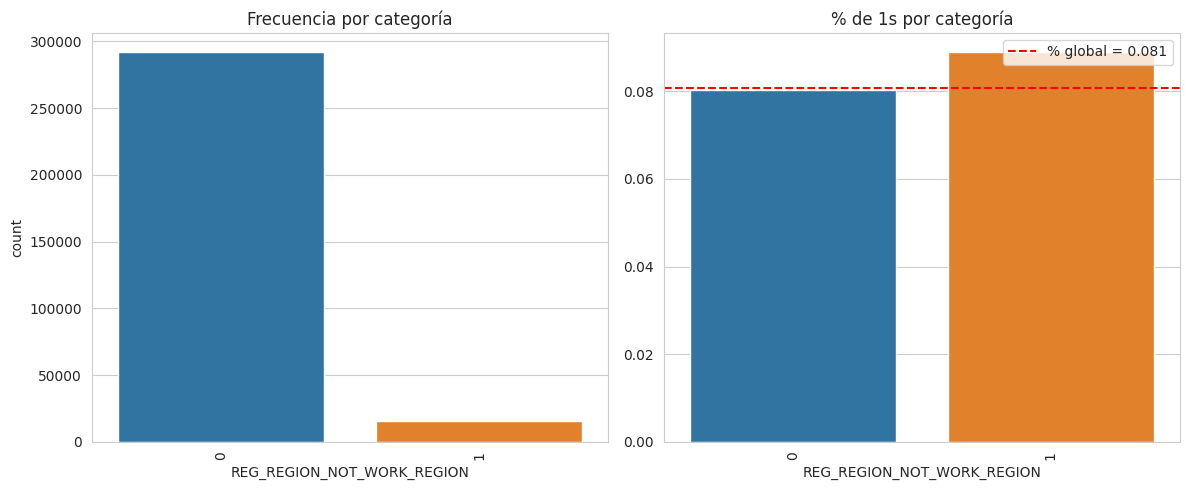

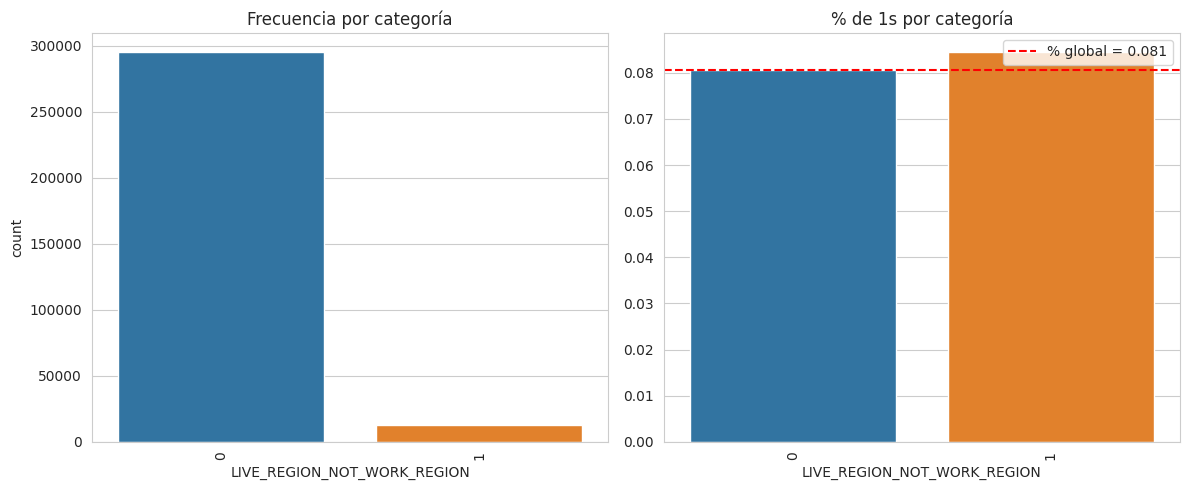

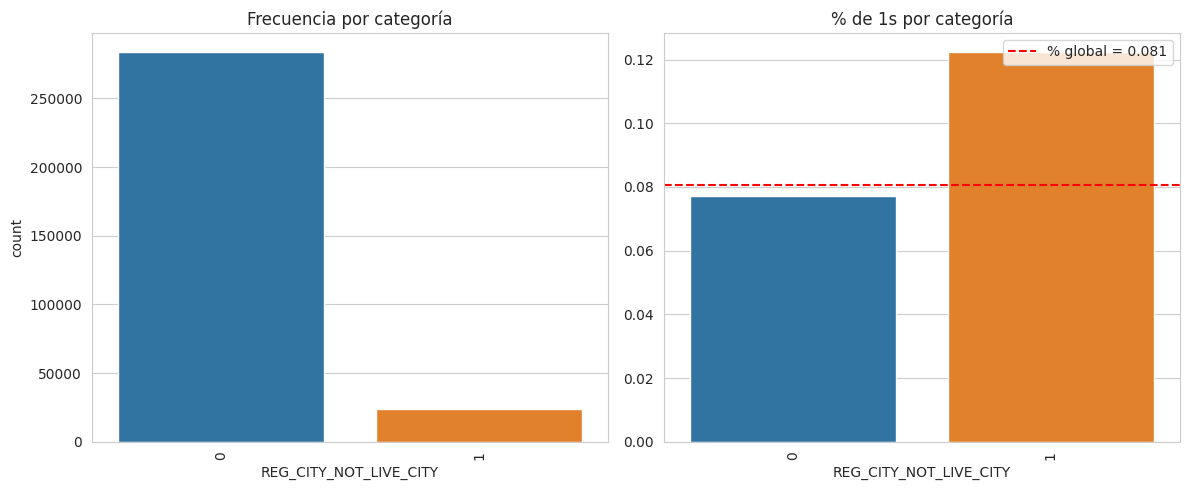

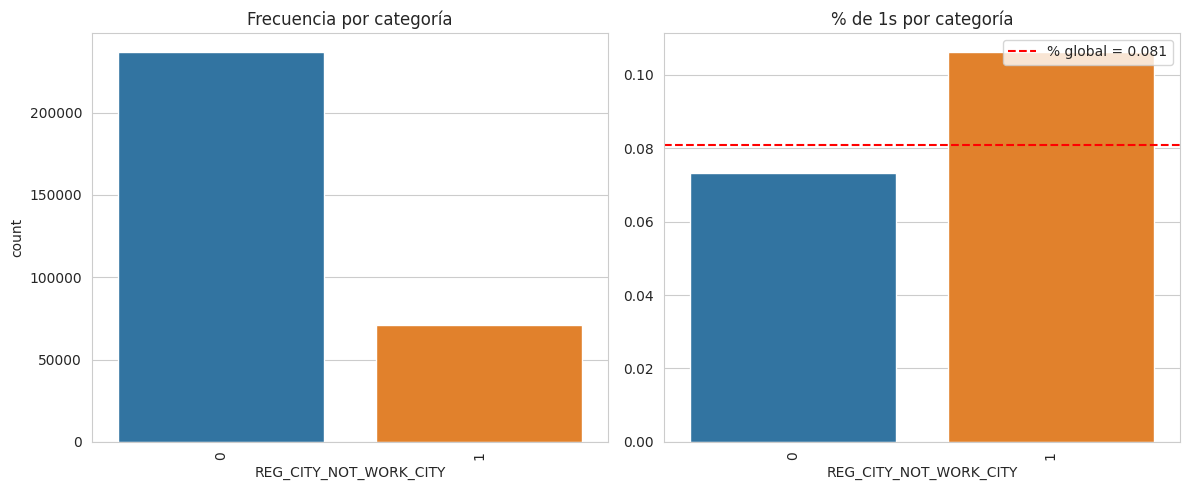

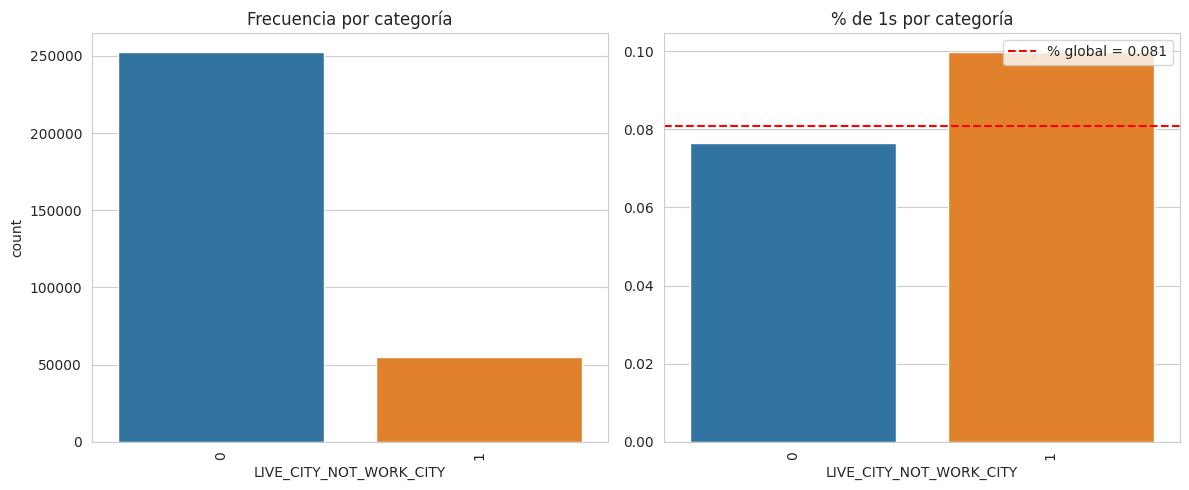

In [29]:
graficar_EDA_target(data,'TARGET',inf_direccion)

#### Informacion scores
- EXTERNAL_SOURCE_1 : Score del cliente (fuente1)
- EXTERNAL_SOURCE_2 : Score del cliente (fuente2)
- EXTERNAL_SOURCE_3 : Score del cliente (fuente3)

In [30]:
data[inf_scores].describe()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
count,134133.000000,3.068510e+05,246546.000000
mean,0.502130,5.143927e-01,0.510853
std,0.211062,1.910602e-01,0.194844
min,0.014568,8.173617e-08,0.000527
25%,0.334007,3.924574e-01,0.370650
50%,0.505998,5.659614e-01,0.535276
75%,0.675053,6.636171e-01,0.669057
max,0.962693,8.549997e-01,0.896010


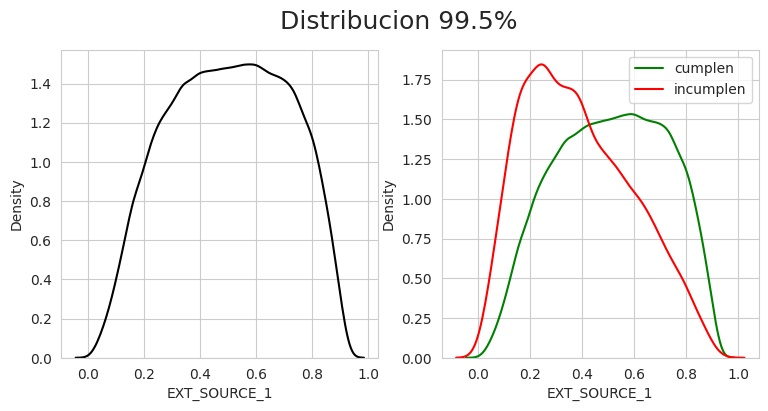

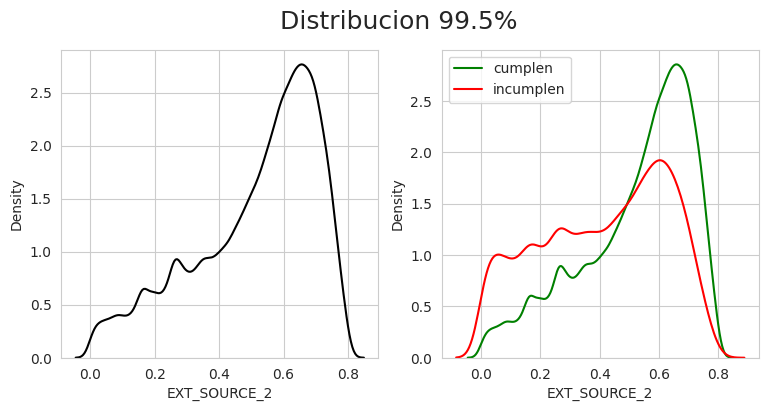

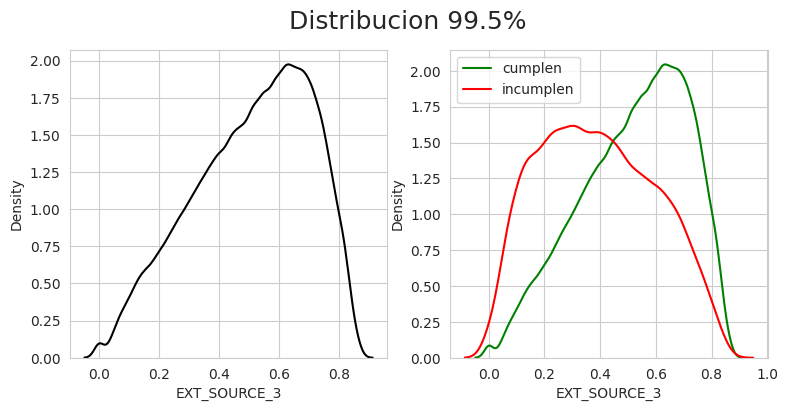

In [31]:
graficar_EDA_target(data,'TARGET',inf_scores)

#### Informacion de llamadas al bureau
1. AMT_REQ_CREDIT_BUREAU_HOUR : Consultas al bureau de credito en la ultima hora sobre ese cliente
2. AMT_REQ_CREDIT_BUREAU_DAY : Consultas al bureau de credito en el ultimo dia sobre ese cliente
3. AMT_REQ_CREDIT_BUREAU_WEEK : Consultas al bureau de credito en la ultima semana sobre ese cliente
4. AMT_REQ_CREDIT_BUREAU_MON : Consultas al bureau de credito en el ultmo mes sobre ese cliente

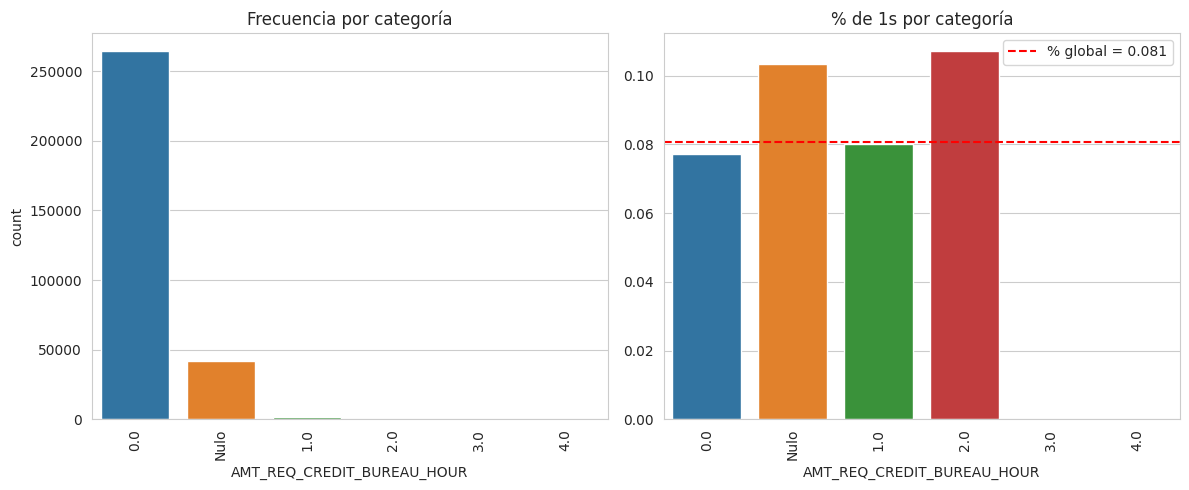

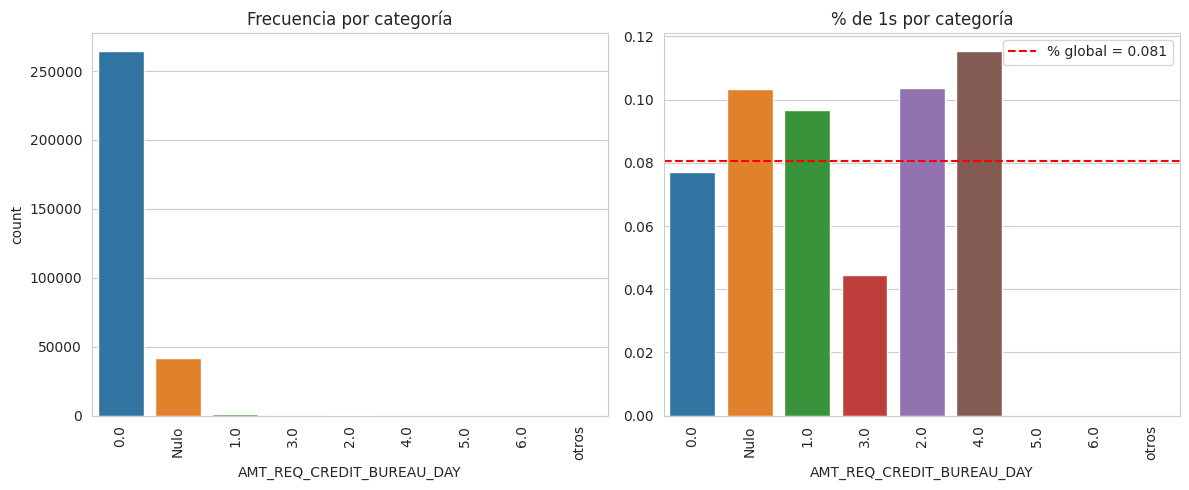

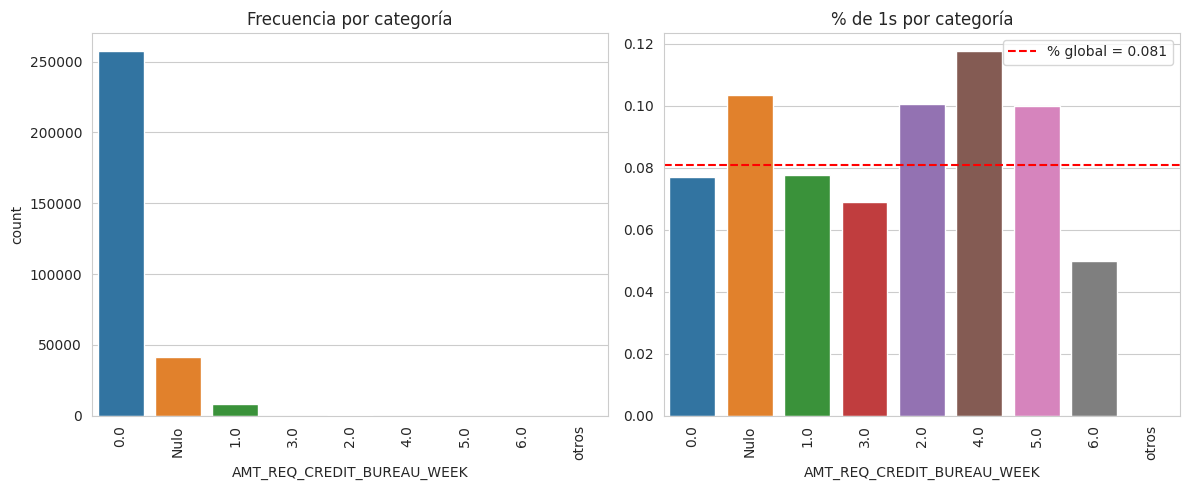

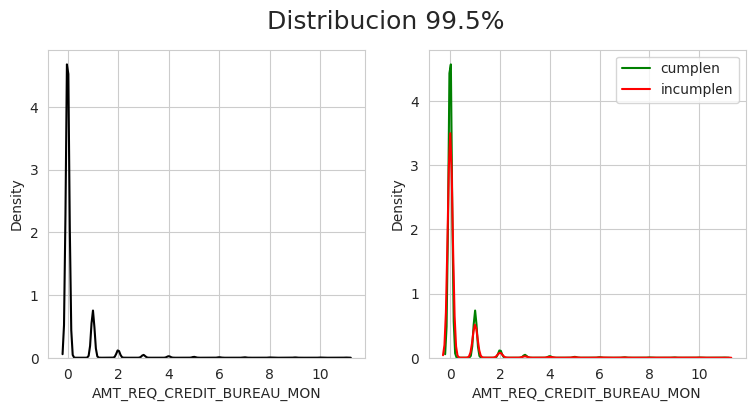

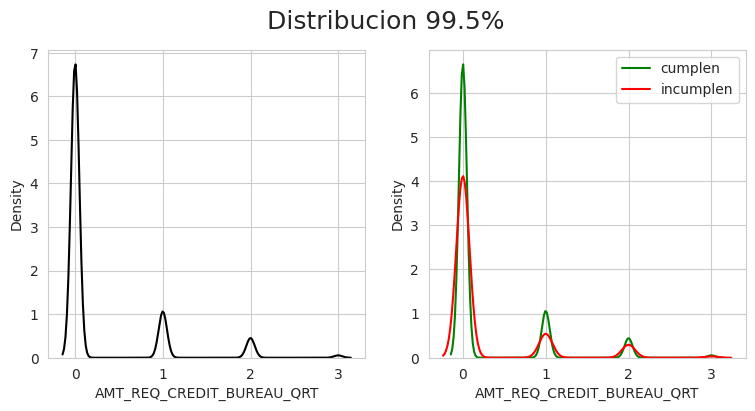

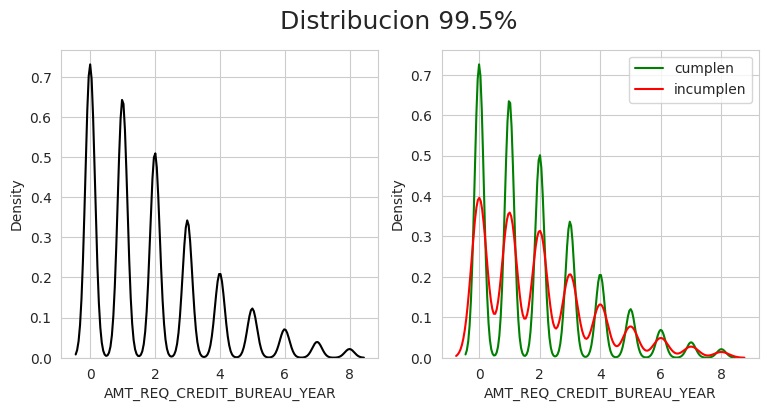

In [32]:
graficar_EDA_target(data,'TARGET',inf_bureauCalls)

## Bureau y Bureau balance

In [4]:
bureau = leer_csv_desde_gcs(archivo = "bureau.csv")
bureau_balance = leer_csv_desde_gcs(archivo = "bureau_balance.csv")

Leyendo archivo desde: gs://home-credit-risk-data-bucket/data/bureau.csv
Leyendo archivo desde: gs://home-credit-risk-data-bucket/data/bureau_balance.csv


In [ ]:
# Listas de variables de la tabla bureau agrupadas
inf_identificadores = ['SK_ID_CURR','SK_ID_BUREAU']
inf_estado_categoria = ['CREDIT_ACTIVE','CREDIT_CURRENCY','CREDIT_TYPE']
inf_fechas_duraciones = ['DAYS_CREDIT','DAYS_CREDIT_ENDDATE','DAYS_ENDDATE_FACT','DAYS_CREDIT_UPDATE']
inf_metricas_importe = ['AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT',
                        'AMT_CREDIT_SUM_LIMIT','AMT_CREDIT_SUM_OVERDUE']
inf_metricas_mora_extensiones = ['CREDIT_DAY_OVERDUE','AMT_CREDIT_MAX_OVERDUE','CNT_CREDIT_PROLONG']
inf_condiciones_pago = ['AMT_ANNUITY']

#### Informacion Identificadores

- SK_ID_CURR : Identificador único del préstamo actual del cliente en Home Credit.

- SK_ID_BUREAU : Identificador único de cada crédito previo reportado al Buró de Crédito.

#### Informacion de Estado y categoría del crédito
- CREDIT_ACTIVE : Estado del crédito al momento de la solicitud (Active, Closed, Bad debt, …).

- CREDIT_CURRENCY : Moneda en que fue otorgado el crédito (por ejemplo, moneda local vs. extranjera).

- CREDIT_TYPE : Tipo de producto crediticio (Consumer credit, Credit card, Mortgage, Car loan, …).

In [22]:
bureau['CREDIT_ACTIVE'].value_counts()

CREDIT_ACTIVE
Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: count, dtype: int64

In [14]:
client = bigquery.Client()
dataset = "proyecto-datascience-459317.Home_credit_risk"


# Ejecuta y vuelca a DataFrame
query_job = client.query(sql)
df_bureau = query_job.result().to_dataframe()

In [18]:
def consultar_bigquery(sql_):
    client = bigquery.Client()
    dataset = "proyecto-datascience-459317.Home_credit_risk"
    sql_ = sql_.format(dataset)
    query_job = client.query(sql_)
    tabla_resultante = query_job.result().to_dataframe()
    return tabla_resultante

In [20]:
sql = """
SELECT *
FROM {}.bureau
LIMIT 100
"""
consultar_bigquery(sql)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.000,NaN,0.0,Credit card,-20,NaN
1,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
2,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
3,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN
4,162297,5714474,Active,currency 1,-277,0,5261.0,NaN,0.0,0,7033500.0,NaN,NaN,0.0,Mortgage,-31,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,387522,5715807,Active,currency 1,-824,0,NaN,NaN,NaN,0,292500.0,260820.000,NaN,0.0,Credit card,-8,NaN
96,387522,5715811,Active,currency 1,-617,0,10340.0,NaN,2695.5,0,126000.0,NaN,NaN,0.0,Credit card,-7,NaN
97,221655,5715837,Active,currency 1,-665,0,824.0,NaN,NaN,0,667008.0,470647.215,NaN,0.0,Consumer credit,-24,NaN
98,221655,5715838,Active,currency 1,-1076,0,51.0,NaN,NaN,0,423504.0,16222.590,NaN,0.0,Consumer credit,-7,NaN


#### Informacion de Fechas y duraciones

- DAYS_CREDIT : Días transcurridos entre la apertura del crédito y la fecha de solicitud actual (valor negativo indica días en el pasado).

- DAYS_CREDIT_ENDDATE : Días entre la fecha de solicitud y la fecha planificada de finalización del crédito (positivo = en el futuro).

- DAYS_ENDDATE_FACT : Días entre la solicitud y la finalización real del crédito; NaN si aún está activo.

- DAYS_CREDIT_UPDATE : Días desde la última actualización del reporte en el Buró hasta la fecha de solicitud.

In [21]:
print("dsadsa")

dsadsa


#### Información de Métricas de importe

- AMT_CREDIT_SUM : Importe original total del crédito otorgado.

- AMT_CREDIT_SUM_DEBT : Saldo de deuda pendiente al momento de la solicitud.

- AMT_CREDIT_SUM_LIMIT : Límite de crédito (solo para productos revolventes; NaN para créditos a plazo fijo).

- AMT_CREDIT_SUM_OVERDUE : Importe total vencido hasta la fecha de solicitud.

#### Información de Métricas de mora y extensiones

- CREDIT_DAY_OVERDUE : Número de días de atraso en el pago al momento de la solicitud (0 si no hay mora).

- AMT_CREDIT_MAX_OVERDUE : Monto máximo que llegó a estar vencido en todo el historial del crédito.

- CNT_CREDIT_PROLONG : Número de veces que el crédito ha sido prorrogado o extendido.

#### Condiciones de pago

- AMT_ANNUITY : Cuota periódica (anualidad) a pagar para el crédito; NaN si no aplica.